This code has been developed to explore output from the Pinal County model

In [2]:
import flopy
import flopy.utils.binaryfile as bf
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf


import os
import numpy as np
import pandas as pd
import re

import shutil

os.system('cls')

0

Activate this to load and run the Pinal County model

In [3]:
###################################################################################################################
# The following code snippet will load the MODFLOW file
# But it is extremely slow, so it seems better to just overwrite packages and run it from the command line
# Also, several of the ADWR files contain formatting errors, so they won't load unless you fix them
###################################################################################################################

###################################################################################################################
# NOTES:
#     You may need to remove all but the first '#' lines from the GMG file
#     You may find misaliged text in the SWT file near a comment 'COLUMN 195' 
###################################################################################################################

load_pinal_MODFLOW = 0

if load_pinal_MODFLOW == 1:
   model_ws = "D:/tyferre/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/INPUT"
   # model_ws = "C:/Users/tyfer/Documents/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/INPUT"
   ml = flopy.modflow.Modflow.load(
      "PM_AWS2019_SS25115.nam",
      model_ws=model_ws,
      verbose=True,
      version="mf2005",
      check=False
   )


In [4]:
run_original_pinal_MODFLOW = 0

if run_original_pinal_MODFLOW == 1:
    success, buff = ml.run_model(silent=False,report=True)     # run MODFLOW

In [5]:
# Use this block to modify an input file for the model and to rerun MODFLOW
#  Be sure to get all of the output that you want for the unchanged model first and to save it in a folder that will not be overwritten!


Load the head data and store in an array
Load stream leakage data and store in an array

Note that there are 12 time steps per stress period
  Head and cell-by-cell flows are stored for SP1 (initial steady state)
  Heads are stored every time steps
  Flows are stored only for the final (12th) time step for each stress period

In [6]:
#######################################################
# read in the heads
#######################################################

hds = bf.HeadFile('C:/Users/tyfer/Documents/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/OUTPUT/Pinal.hds')                   # reads the binary head file
# hds = bf.HeadFile('D:/tyferre/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/OUTPUT/Pinal.hds')                   # reads the binary head file
times = hds.get_times()
heads = hds.get_data(totim=times[-1])


#######################################################
# store the heads in an array
#######################################################

allheads = np.zeros((len(times),np.shape(heads)[0],np.shape(heads)[1],np.shape(heads)[2]))
for i in np.arange(len(times)):
    allheads[i,:] = hds.get_data(totim=times[i])

print("allheads file size as times, layers, rows, columns: ", np.shape(allheads))
print()


#######################################################
# Read the locations of the stream cells, previously written to an Excel file - it should be possible to read this from one of the input files directly
#######################################################

df = pd.read_excel('C:/Users/tyfer/Documents/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/INPUT/str_cells_Pinal.xlsx')
# df = pd.read_excel('D:/tyferre/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/INPUT/str_cells_Pinal.xlsx')
str_cells = df.to_numpy()
# print(str_cells)


#######################################################
# Read the leakage at every stream cell
#######################################################

cbb = bf.CellBudgetFile('C:/Users/tyfer/Documents/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/OUTPUT/Pinal.cbb')                          # reads the cell budget file 
# cbb = bf.CellBudgetFile('D:/tyferre/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/OUTPUT/Pinal.cbb')                          # reads the cell budget file 
df = pd.read_excel('C:/Users/tyfer/Documents/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/INPUT/str_cells_Pinal.xlsx')
# df = pd.read_excel('D:/tyferre/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/INPUT/str_cells_Pinal.xlsx')
strresults_list = cbb.get_data(text='STREAM LEAKAGE')     # returns an array of leakage rates in stream
strresults = np.array(strresults_list)      # convert list to array
str_times = np.array(cbb.get_kstpkper())

# note that there are two times when leakage is printed that are NOT end of year: step1 (Feb) SP 84, and step4 (May) SP 167
# for now, these two times are removed so that stream leakage is reported annually
non_Dec_data = np.squeeze((np.where(str_times[:,0]<11)))         # find dates for white step < 11
non_Dec_data = non_Dec_data[1:]                                  # do not include initial steady state result
strresults = np.delete(strresults, non_Dec_data, axis=0)

str_leak = np.zeros((np.shape(strresults)[0],np.shape(str_cells)[0]))
for j in np.arange(np.shape(str_leak)[0]):
    for i in np.arange(np.shape(str_cells)[0]):
        str_leak[j,i] = strresults[j][0][str_cells[i,0]][str_cells[i,1]]

print("str_leak file size as times, stream cells: ", np.shape(str_leak))
print()

str_leak_mean = np.mean(str_leak, axis=0)
str_leak_var = np.var(str_leak, axis=0)

highest_var_cell = np.where(str_leak_var == np.max(str_leak_var))
num_str_cells = np.shape(str_cells)[0]
num_years = np.shape(str_leak)[0]

tempflowtimes= np.arange(12,len(times),12, dtype=int)
flowtimes = np.zeros((len(tempflowtimes)+1))
flowtimes[1:] = tempflowtimes
flowtimes = np.array(flowtimes, dtype = int)
allheads_flowtimes = allheads[flowtimes, :, :, :]

print("allheads_flowtimes as times, stream cells: ", np.shape(allheads_flowtimes))
print()





allheads file size as times, layers, rows, columns:  (2317, 3, 196, 222)

str_leak file size as times, stream cells:  (194, 189)

allheads_flowtimes as times, stream cells:  (194, 3, 196, 222)



The following block reads the stream leakage through time along the Gila.
It assumes that the stream cells have been stored in str_cells_Pinal.xlsx as layer, column, row with a header line

Stream leakage versus year for each cell


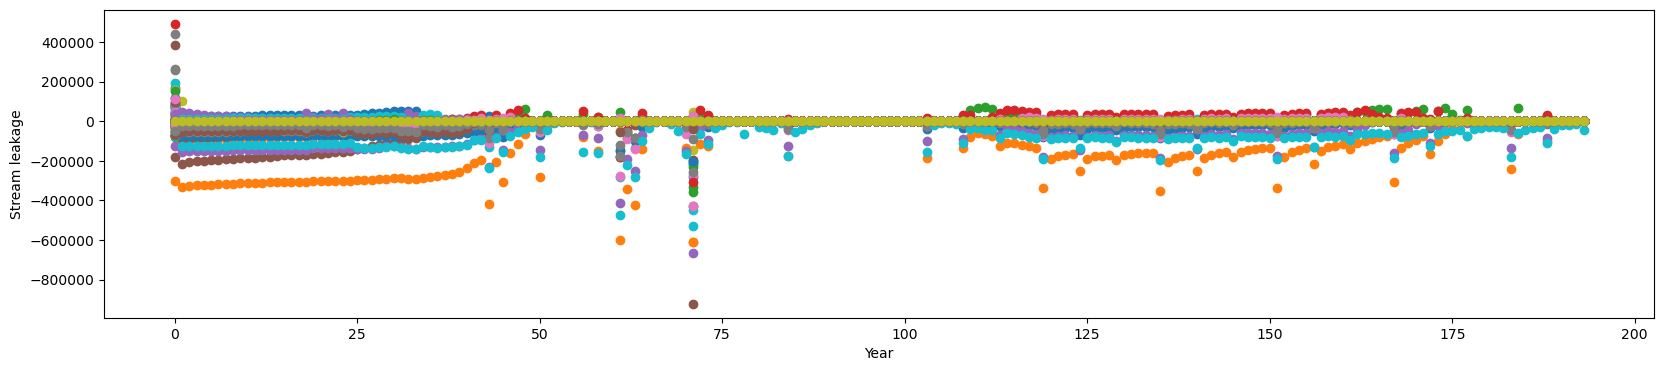

Stream leakage versus cell number for each year


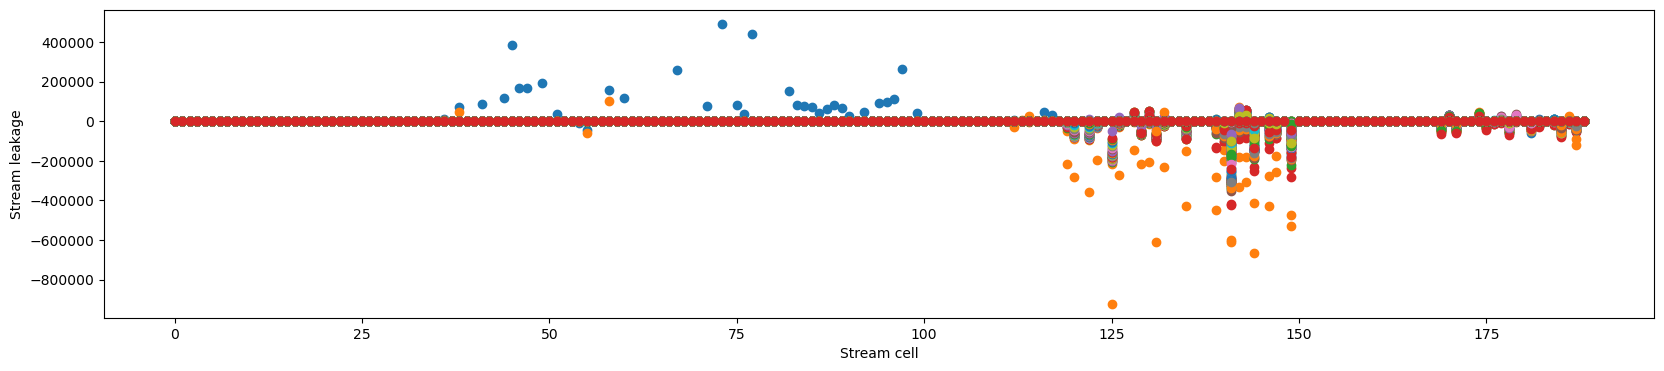

Stream leakage versus location for selected years


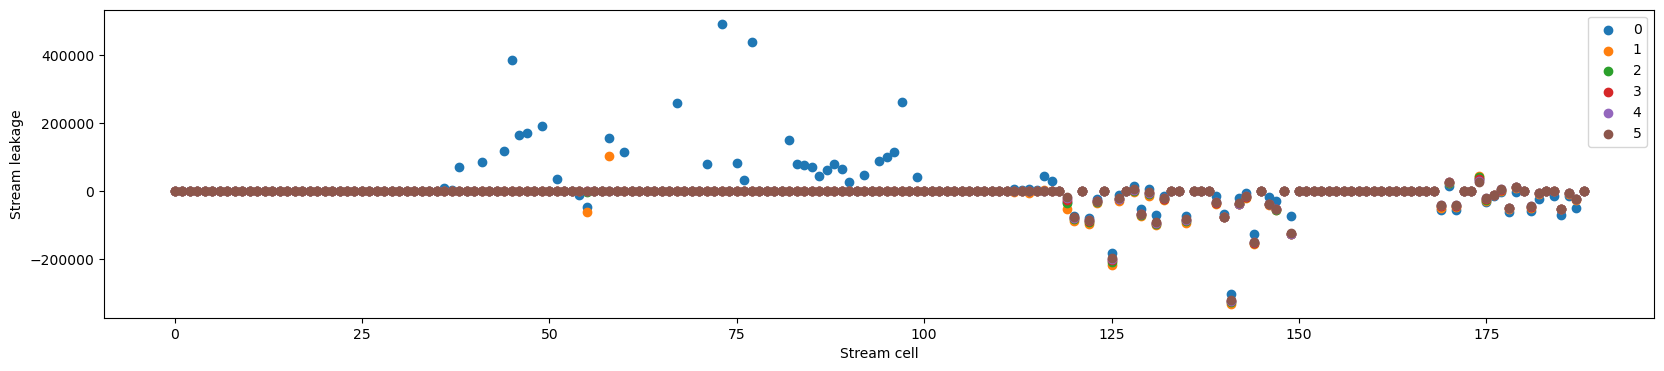

Stream leakage versus year for selected locations


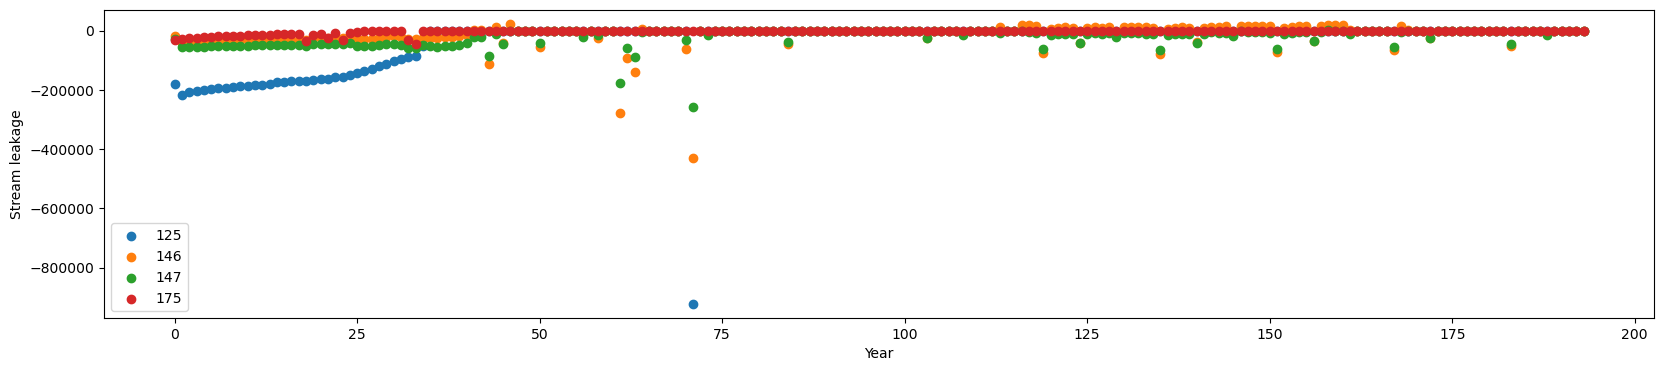

Contour of log10 of stream leakage on surface of time versus location
(194, 189)
-922038.0625 492047.6875
-1.0 5.964748896563578


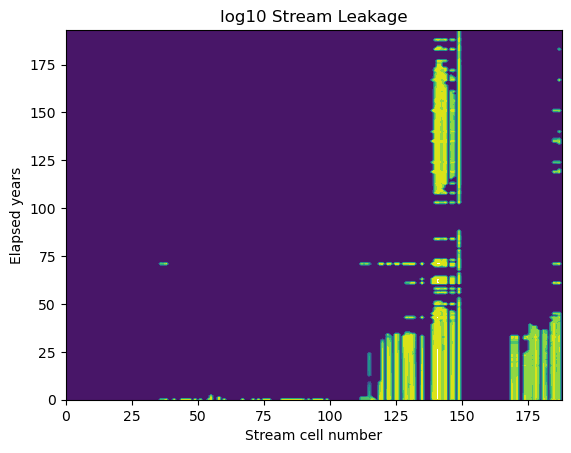

Total stream leakage versus year over all cells


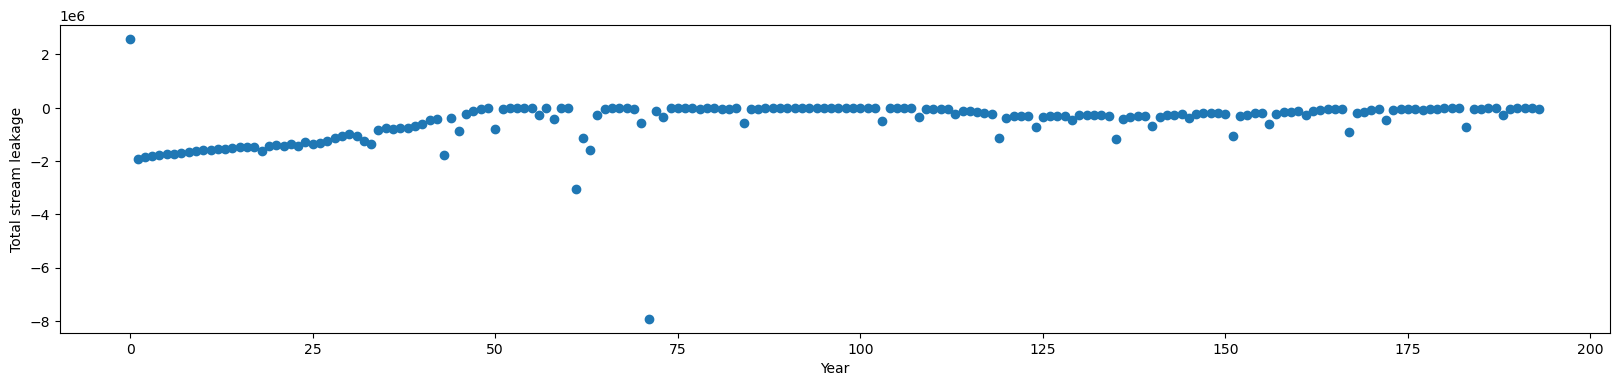

Mean stream leakage along stream over all years


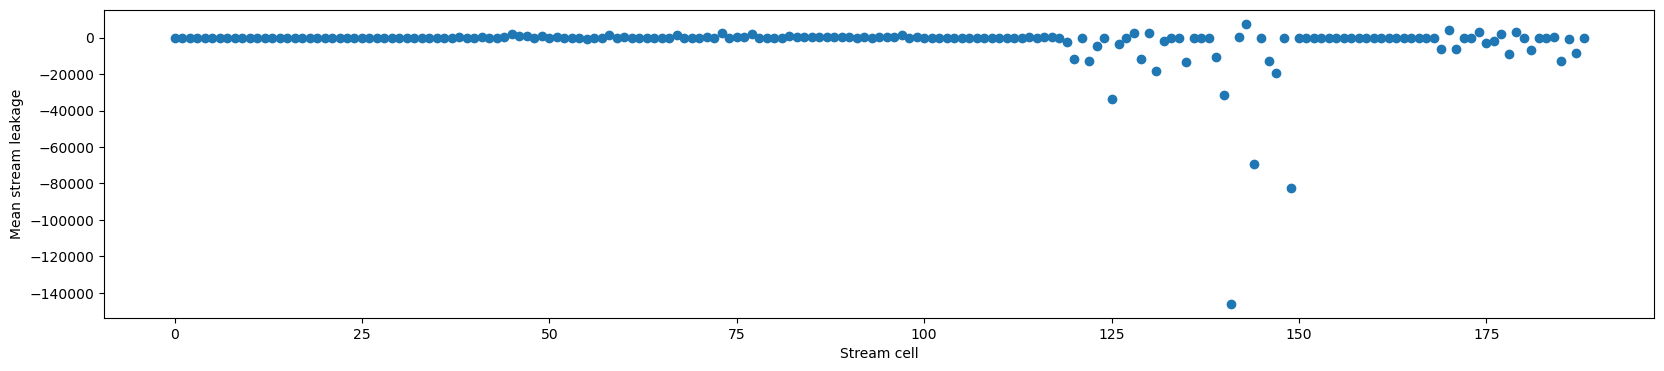

Variance of Mean stream leakage along stream over all years


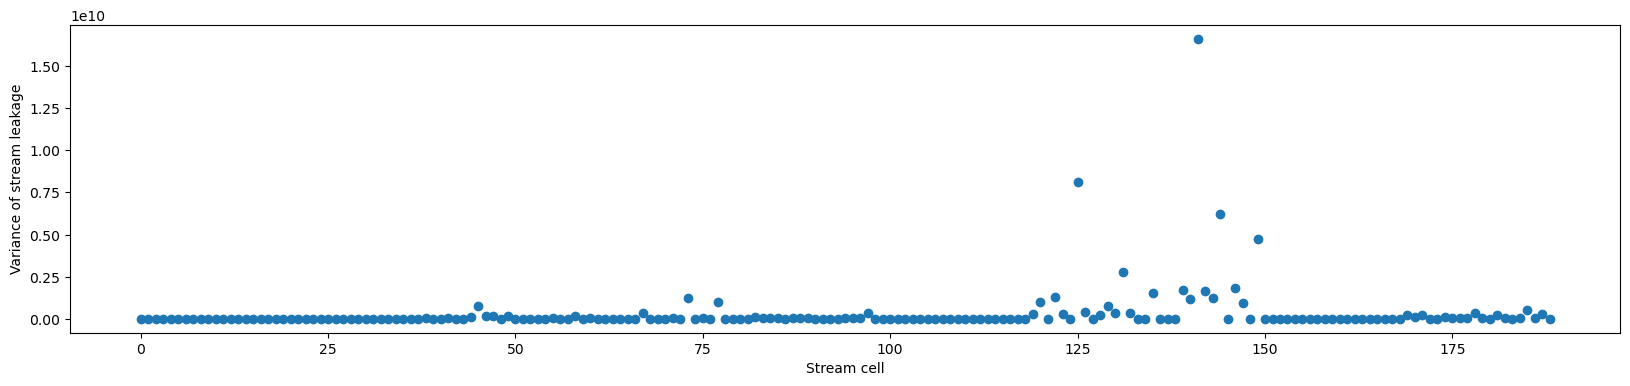

Stream leakage through time at location of largest variance over time


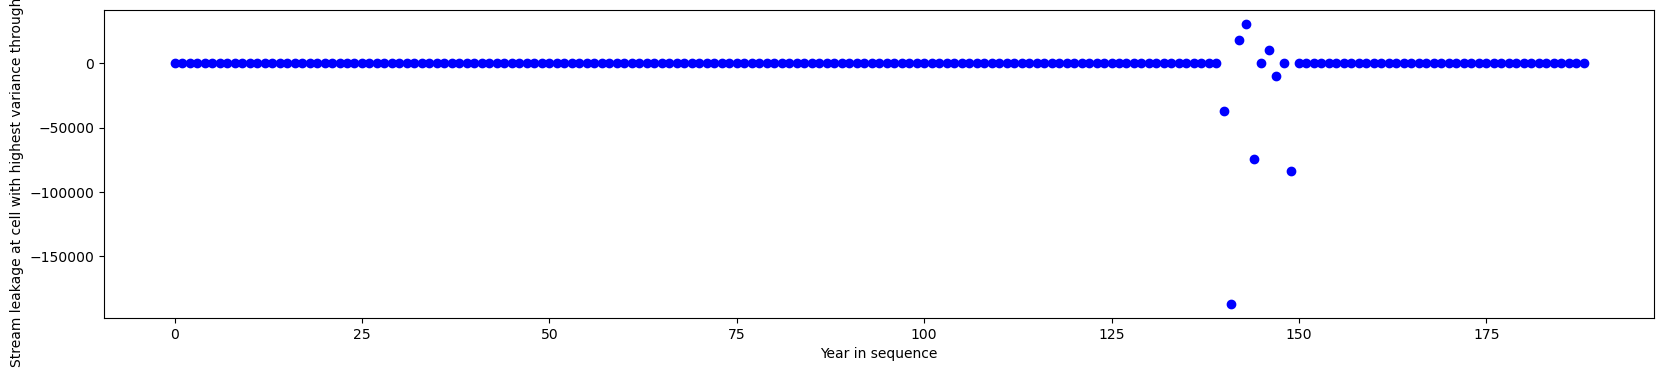

In [7]:
# np.savetxt('leakages.txt', str_leak, delimiter = ",")


print('Stream leakage versus year for each cell')
f1,ax1 = plt.subplots(1,1,figsize=(20,4))  
for i in np.arange(num_str_cells):         
    c = ax1.scatter(np.arange(num_years),str_leak[:, i])
plt.xlabel("Year")
plt.ylabel("Stream leakage")
plt.show(f1)                                                  # display plot (not always necessary)

print('Stream leakage versus cell number for each year')
f2,ax1 = plt.subplots(1,1,figsize=(20,4))  
for i in np.arange(num_years):         
    c = ax1.scatter(np.arange(num_str_cells),str_leak[i, :])
plt.xlabel("Stream cell")
plt.ylabel("Stream leakage")
plt.show(f1)                                                  # display plot (not always necessary)

print('Stream leakage versus location for selected years')
years2plot = [0, 1, 2, 3, 4, 5]         # choose years to show
f3,ax1 = plt.subplots(1,1,figsize=(20,4))  
for i in np.arange(len(years2plot)):         
    c = ax1.scatter(np.arange(num_str_cells),str_leak[years2plot[i], :], label=str(years2plot[i]) )
plt.xlabel("Stream cell")
plt.ylabel("Stream leakage")
plt.legend()
plt.show(f2)                                                  # display plot (not always necessary)

print('Stream leakage versus year for selected locations')
cells2plot = [125, 146, 147, 175]         # choose years to show
f3,ax1 = plt.subplots(1,1,figsize=(20,4))  
for i in np.arange(len(cells2plot)):         
    # c = ax1.scatter(np.arange(num_str_cells),str_leak[i,:])
    c = ax1.scatter(np.arange(num_years),str_leak[:, cells2plot[i]], label=str(cells2plot[i]) )
plt.xlabel("Year")
plt.ylabel("Stream leakage")
plt.legend()
plt.show(f2)                                                  # display plot (not always necessary)

print('Contour of log10 of stream leakage on surface of time versus location')
f3, ax1 = plt.subplots(1, 1) 
y = np.arange(num_years)
x = np.arange(num_str_cells)
[X, Y] = np.meshgrid(x, y) 
print(np.shape(str_leak))
print(np.min(str_leak), np.max(str_leak))
min_contour = np.min(np.min(np.log10(np.abs(str_leak)+0.1)))
max_contour = np.max(np.max(np.log10(np.abs(str_leak)+0.1)))
print(min_contour, max_contour)
num_contour = 10
contour_interval = (max_contour - min_contour) / num_contour
levels = np.arange(min_contour, max_contour, contour_interval)
c = ax1.contourf(X, Y, np.log10(np.abs(str_leak)+0.1), levels=levels) 
plt.title('log10 Stream Leakage') 
plt.xlabel('Stream cell number') 
plt.ylabel('Elapsed years') 
plt.show() 

print('Total stream leakage versus year over all cells')
annual_str_sum = np.sum(str_leak,1)
f1,ax1 = plt.subplots(1,1,figsize=(20,4))  
c = ax1.scatter(np.arange(num_years),annual_str_sum)
plt.xlabel("Year")
plt.ylabel("Total stream leakage")
plt.show(f1)                                                  # display plot (not always necessary)

print('Mean stream leakage along stream over all years')
f1,ax1 = plt.subplots(1,1,figsize=(20,4))  
c = ax1.scatter(np.arange(num_str_cells),str_leak_mean)
plt.xlabel("Stream cell")
plt.ylabel("Mean stream leakage")
plt.show(f1)                                                  # display plot (not always necessary)

print('Variance of Mean stream leakage along stream over all years')
f2,ax1 = plt.subplots(1,1,figsize=(20,4))  
c = ax1.scatter(np.arange(num_str_cells),str_leak_var)
plt.xlabel("Stream cell")
plt.ylabel("Variance of stream leakage")
plt.show(f2)                                                  # display plot (not always necessary)

print('Stream leakage through time at location of largest variance over time')
f4,ax1 = plt.subplots(1,1,figsize=(20,4))  
for i in np.arange(np.shape(str_leak)[1]):         
    c = ax1.scatter(i,str_leak[highest_var_cell,i], c = 'b')
plt.xlabel("Year in sequence")
plt.ylabel("Stream leakage at cell with highest variance through time")
plt.show(f4)                                                  # display plot (not always necessary)






In [8]:
rows = len(strresults_list)

columns = [len(item) for item in strresults_list]

# Combine the rows and columns in one list
shape = [rows, columns]

print(shape)
print(str_times)
print(np.shape(str_times))
test = np.array(str_times)
print(np.shape(test))
print(test)

[196, [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]
[[  0   0]
 [ 11   1]
 [ 11   2]
 [ 11   3]
 [ 11   4]
 [ 11   5]
 [ 11   6]
 [ 11   7]
 [ 11   8]
 [ 11   9]
 [ 11  10]
 [ 11  11]
 [ 11  12]
 [ 11  13]
 [ 11  14]
 [ 11  15]
 [ 11  16]
 [ 11  17]
 [ 11  18]
 [ 11  19]
 [ 11  20]
 [ 11  21]
 [ 11  22]
 [ 11  23]
 [ 11  24]
 [ 11  25]
 [ 11  26]
 [ 11  27]
 [ 11  28]
 [ 11  29]
 [ 11  30]
 [ 11  31]
 [ 11  32]
 [ 11  33]
 [ 11  34]
 [ 11  35]
 [ 11  3

Processing wel file

195  stress periods
2  layers
192  rows
213  columns

Size of alldata  (255493, 5)

size alldata =  255493
size where_wells =  (2, 192, 213)
Number of wells =  3900.0
Individual well pumping through time
708.9686
(array([], dtype=int64),)
1
[] 0 []


ValueError: x and y must be the same size

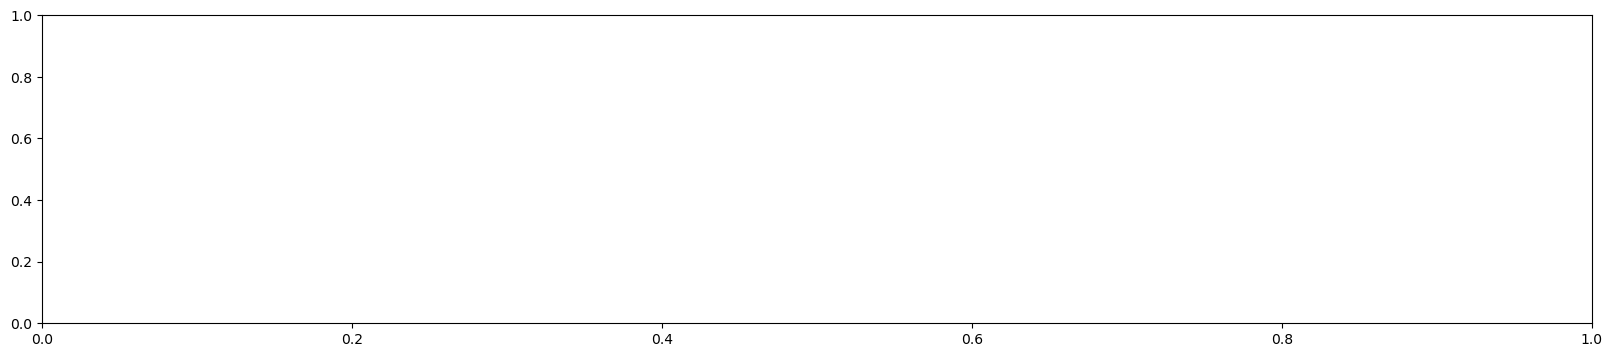

In [29]:
###################################################################################################################
# The following code snippet reads the WEL package
###################################################################################################################
headerlines = 0
icounters = 0
isps = 0
counters = np.zeros((500))
alldata = np.zeros((5,500000))
print('Processing wel file')
# with open('D:/tyferre/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/model_Files/INPUT/PM_PUMP_SS_2015_SPFLUX_SS_2115_ORIGINAL.wel') as fp:
with open('C:/Users/tyfer/Documents/frequent/Courses/professional_MS/projects/pinal_county/from_adwr/Model_Files/INPUT/PM_PUMP_SS_2015_SPFLUX_SS_2115_ORIGINAL.wel') as fp:
    for line in fp:
        readline = line 
        # print(line)
        words = re.split(r'\s+', line)
        if words[0] == "#":                             # identify the comment lines at the top of the input file
            headerlines += 1    
        else:    # after the header lines
            if words[3] == "":                          # skip the blank line before the stress period identifier
                bigcounter = (words[1], words[2])
            elif words[3] == "Stress":                  # stress period identifier
                counters[icounters] = int(words[5])     # record the stress period number
                icounters += 1 
            elif words[3] != "Stress":                  # actual pumping records
                # print(readline[0:11], readline[11:21], readline[21:31], readline[31:41])
                # print(words)
                alldata[:,isps] = (int(words[1])-1, int(words[2])-1, int(words[3])-1, float(words[4]), counters[icounters-1])    # layer, row, column, rate, stress period
                isps += 1                               # counter of number of pumping data entries identified
numspds = int(np.max(counters))
numlayers = int(np.max(alldata[0,:]))
numrows = int(np.max(alldata[1,:]))
numcolumns = int(np.max(alldata[2,:]))
sum_rows = np.sum(alldata, 0)
max_rows = np.max(alldata, 0)
first_empty_row = np.min(np.where((sum_rows ==0) & (max_rows ==0)))
alldata = alldata[:,0:first_empty_row]
print()
print(numspds+1, ' stress periods')
print(numlayers, ' layers')
print(numrows, ' rows')
print(numcolumns, ' columns')
numlines = int(np.max(np.where(alldata[0,:]>0)))+1   
alldata = alldata[:,0:numlines]
alldata = np.rot90(alldata)
alldata = np.flip(alldata,0)
print() 
print("Size of alldata ", np.shape(alldata))
print()

where_wells = np.zeros((numlayers, numrows, numcolumns))
print("size alldata = ", np.shape(alldata)[0])
print("size where_wells = ", np.shape(where_wells))
for i in np.arange(np.shape(alldata)[0]):
    # print(int(alldata[i,0]))
    # print(int(alldata[i,1]))
    # print(int(alldata[i,2]))
    # print()
    where_wells[int(alldata[i,0])-1, int(alldata[i,1]-1), int(alldata[i,2]-1)] = 1
numwells = np.sum(where_wells)
print("Number of wells = ", numwells)

###################################################################################################################
# Sum range of individual well pumpage for each stress period
###################################################################################################################
print('Individual well pumping through time')
print(alldata[103, 3])
f4,ax1 = plt.subplots(1,1,figsize=(20,4))  
for i in np.arange(np.max(alldata[:,4])):
    find_sp = np.where(alldata[:,4] == i)
    print(find_sp)
    print(len(find_sp))
    if len(find_sp) > 0:
        for j in np.arange(np.shape(find_sp)[0]):
            print(find_sp[j], j,alldata[find_sp[j], 3])
            c = ax1.scatter(j,alldata[find_sp[j], 3], c = 'b')
plt.xlabel("Year in sequence")
plt.ylabel("Total pumping")
plt.show(f4)                                                  # display plot (not always necessary)

###################################################################################################################
# Sum total pumpage for each stress period
###################################################################################################################
total_pumping = np.zeros((int(np.max(alldata[:,4]))))
for i in np.arange(np.max(alldata[:,4])):
    find_sp = np.where(alldata[:,4] == i)
    total_pumping[int(i)] = np.sum(alldata[find_sp,3])

print('Total pumping through time')
f4,ax1 = plt.subplots(1,1,figsize=(20,4))  
for i in np.arange(np.shape(total_pumping)[0]):         
    c = ax1.scatter(i,total_pumping[i], c = 'b')
plt.xlabel("Year in sequence")
plt.ylabel("Total pumping")
plt.show(f4)                                                  # display plot (not always necessary)

###################################################################################################################
# The following code snippet assigns a name for every cell that includes pumping in each of the three layers
###################################################################################################################
pumped_wells_1 = []
pumped_wells_2 = []
pumped_wells_3 = []
for i in np.arange(np.shape(alldata)[0]):
    layer_str = str(int(alldata[i,0]))
    row_str = str(int(alldata[i,1]))
    column_str = str(int(alldata[i,2]))
    add0_str = ""
    if alldata[i,0] < 10:
        add0_str = "00"
    elif alldata[i,0] < 100:
        add0_str = "0"
    add1_str = ""
    if alldata[i,1] < 10:
        add1_str = "00"
    elif alldata[i,1] < 100:
        add1_str = "0"
    add2_str = ""
    if alldata[i,2] < 10:
        add2_str = "00"
    elif alldata[i,2] < 100:
        add2_str = "0"
    temp_str = add0_str + layer_str + add1_str + row_str + add2_str + column_str
    if int(alldata[i,0]) == 0:
        pumped_wells_1.append(temp_str)
    elif int(alldata[i,0]) == 1:
        pumped_wells_2.append(temp_str)
    else:
        pumped_wells_3.append(temp_str)
myset_1 = set(pumped_wells_1)
myset_2 = set(pumped_wells_2)
myset_3 = set(pumped_wells_3)
well_ids_1 = list(myset_1)
well_ids_2 = list(myset_2)
well_ids_3 = list(myset_3)
well_ids_1.sort()
well_ids_2.sort()
well_ids_3.sort()

hold_alldata = alldata * 1.

print(np.shape(well_ids_1))
print(well_ids_1)

In [15]:
print(np.shape(total_pumping))

(194,)
